# <center>  Assignment 1 - Toronto Bike Share: Analysis on Ridership Behaviour </center>
### <center> Karl Hendrik Nurmeots </center>
<center>  February 5, 2020 </center>


***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import seaborn as sns
import re
from IPython.display import display, HTML

In [2]:
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [15,7]

# Introduction

This report aims to analyze how Toronto Bike Share customer behaviour is affected by various parameters. More precisely, we will take a look at how trip length, which we will soon better define, is affected by these factors.

We will aim to answer the following questions:

- How can we measure the 'length' of trips?
- How are these different definitions of 'length' related to each other?
- Is trip 'length' different for customers who are regular members vs. those who use a temporary pass?
- How do the present season or weather conditions affect trip 'length'?

This report takes some inspiration from the report [Exploring Toronto Bike Share Ridership using Python](https://towardsdatascience.com/exploring-toronto-bike-share-ridership-using-python-3dc87d35cb62), written by Yizhao Tan.

# Abstract

We have provided two definitions for trip length: the trip's duration in seconds, present in the original dataset under `trip_duration_seconds`, and the trip's distance measured as the straight line distance between the trip's start and end stations.

There is a weak positive relationship between these two definitions. There appears to be an exponential relationship, however the data has a lot of variance.

The large majority of trips are performed by members. Trip duration distributions are very different for members and casual users (i.e. those using a temporary pass): casual users tend to go on much longer lasting trips. For trip distance, however, the distributions look very similar in terms of shape.

There were roughly 5 times more trips completed during summer and autumn months compared to winter and spring months. Regardless, for both definitions of trip length the distributions appear to be identical in terms of shape across all four seasons. One can notice how trip durations are on average shorter during winter compared to summer, but these differences are merely a couple of minutes, and could hence be insignificant.

Using meteorological data on the mean temperature and total precipitation for the day each trip was started on, we saw that trips were much more frequent on days with warmer mean temperatures, and on days with no or extremely little precipitation. We noticed tendencies that both trip duration and distance decreased as the daily mean temperature decreased, or as total precipitation increased. However, there is very little to no correlation between the meteorological data and trip length, and so it appears that the tendencies are caused by the underlying trip frequency distributions with respect to mean temperature and precipitation.

# Data

This report uses official [Toronto Bike Share ridership data](https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/) from Q3 and Q4 of 2016, and the entirety of 2017. To accompany this, we will also use [Bike Share station information](https://open.toronto.ca/dataset/bike-share-toronto/). We will scrape the weather data from the [Government of Canada historical climate database](https://climate.weather.gc.ca/).

Per the [terms and conditions of canada.ca](https://www.canada.ca/en/transparency/terms.html), we are permitted to scrape the data for non-commercial use as long as we:
> - exercise due diligence in ensuring the accuracy of the materials reproduced
> - indicate both the complete title of the materials reproduced, as well as the author (where available)
> - indicate that the reproduction is a copy of the version available at [URL where original document is available]

Use of this data for commercial purposes is not allowed without special permission. We will be sure to adhere to these requirements for this report.

### Toronto Bike Share Data

First, let us take a look at the Bike Share data.

In [3]:
# Reading in the data.
q1_2017 = pd.read_csv("Bikeshare Ridership (2017 Q1).csv")
q2_2017 = pd.read_csv("Bikeshare Ridership (2017 Q2).csv")
q3_2017 = pd.read_csv("Bikeshare Ridership (2017 Q3).csv")
q4_2017 = pd.read_csv("Bikeshare Ridership (2017 Q4).csv")
q3_2016 = pd.read_excel("bikeshare-ridership-2016-q3.xlsx")
q4_2016 = pd.read_excel("bikeshare-ridership-2016-q4.xlsx")

In [4]:
q1_2017.head()

trip_id trip_start_time trip_stop_time  trip_duration_seconds  \
0   712382   1/1/2017 0:00  1/1/2017 0:03                    223   
1   712383   1/1/2017 0:00  1/1/2017 0:05                    279   
2   712384   1/1/2017 0:05  1/1/2017 0:29                   1394   
3   712385   1/1/2017 0:07  1/1/2017 0:21                    826   
4   712386   1/1/2017 0:08  1/1/2017 0:12                    279   

   from_station_id                  from_station_name  to_station_id  \
0             7051  Wellesley St E / Yonge St Green P           7089   
1             7143           Kendal Ave / Bernard Ave           7154   
2             7113       Parliament St / Aberdeen Ave           7199   
3             7077                 College Park South           7010   
4             7079              McGill St / Church St           7047   

                 to_station_name user_type  
0           Church St  / Wood St    Member  
1        Bathurst Subway Station    Member  
2      College St W / Markham St    Member  
3        King St W / Spadina Ave    Member  
4  University Ave / Gerrard St W    Member

In [5]:
q3_2016.head()

trip_id     trip_start_time      trip_stop_time  trip_duration_seconds  \
0    53279 2016-07-09 01:03:00 2016-07-09 01:15:00                    714   
1    53394 2016-07-09 02:15:00 2016-07-09 02:22:00                    417   
2    58314 2016-07-10 17:04:00 2016-07-10 17:36:00                   1904   
3    60784 2016-07-11 01:45:00 2016-07-11 01:58:00                    784   
4    93164 2016-07-18 13:35:00 2016-07-18 13:42:00                    443   

                      from_station_name  \
0        Dundas St E / Regent Park Blvd   
1  Riverdale Park North (Broadview Ave)   
2        Dundas St E / Regent Park Blvd   
3                         Union Station   
4            Front St W / Blue Jays Way   

                             to_station_name user_type  
0                Danforth Ave / Ellerbeck St    Member  
1             Dundas St E / Regent Park Blvd    Member  
2                     Queen St W / Close Ave    Member  
3             Dundas St E / Regent Park Blvd    Member  
4  Front St / Yonge St (Hockey Hall of Fame)    Member

Above are shown the first couple of rows in the Q1 2017 and Q3 2016 datasets respectively. The datasets contain the following variables:

`trip_id`: unique identifier for each trip. <br>
`trip_start_time`: date and time of the beginning of the trip.<br>
`trip_stop_time`: date and time of the end of the trip.<br>
`trip_duration_seconds`: the duration of the trip in seconds.<br>
`from_station_name`: the name of the station where the trip began from.<br>
`to_station_name`: the name of the station where the trip ended.<br>
`user_type`: shows whether the user has a Bike Share membership or purchased a temporary pass.<br>

Note that the Q1 2017 dataset also contains the variables `to_station_id` and `from_station_id`, which are not present in the Q3 2016 dataset. Hence, once we get to working with the data, we will omit these columns from the databases they are present in.

There are also several other inconsistencies and issues with the data: note how the trip start and end times are formatted differently in the datasets. We will have to standardize this.

Furthermore, in the data there are strangely short trips that start and end at the same station:

In [6]:
q4_2017.loc[363400:363404:3]

trip_id    trip_start_time     trip_stop_time  trip_duration_seconds  \
363400  2383642  12/31/17 23:46:27  12/31/17 23:46:53                     26   
363403  2383645  12/31/17 23:49:08  12/31/17 23:49:34                     26   

               from_station_name           to_station_name user_type  
363400  Bloor St / Brunswick Ave  Bloor St / Brunswick Ave    Casual  
363403   Phoebe St / Spadina Ave   Phoebe St / Spadina Ave    Member

Toronto Bike Share considers valid trips to be those that are at least 60 seconds long, so we will exclude trips shorter than this from our analysis. In total, there are nearly 13 000 trips that start and end at the same station, but bare in mind that many of these could be valid trips.

Finally, we will also exclude any trips with missing data, and combine all of the separate datasets into a single big one.

In [7]:
# Drop the station ID information 
q1_2017 = q1_2017.drop(columns = ['from_station_id', 'to_station_id'])
q2_2017 = q2_2017.drop(columns = ['from_station_id', 'to_station_id'])

# Create the combined dataframe
df = pd.concat([q3_2016, q4_2016, q1_2017, q2_2017, q3_2017, q4_2017], ignore_index=True)
# Convert the trip start and stop times to datetime objects
df["trip_start_time"] = pd.to_datetime((df["trip_start_time"]), errors = 'coerce')
df["trip_stop_time"] = pd.to_datetime((df["trip_stop_time"]), errors = 'coerce')
# Remove trips shorter than 60 seconds
df = df[df.trip_duration_seconds >= 60]

In [8]:
# Remove trips with missing data
df = df.dropna()

We will create a new column named `season`, representing the season (winter, spring, summer, autumn) the trip took place in based on the month the trip took place on.

In [9]:
def get_season(row):
    """Takes in a pandas Series representing info about a trip, and returns the season the 
    trip took place in."""
    month = int(row.trip_start_time.strftime('%m'))
    if month in [12, 1, 2]: 
        return 'winter'
    elif month in [3, 4, 5]: 
        return 'spring'
    elif month in [6, 7, 8]: 
        return 'summer'
    else: 
        return 'autumn'

df['season'] = df.apply(lambda row: get_season(row), axis=1)

We will go into more detail about this later, but we also would like to find out what is the physical distance between the start and end stations. To do so, we will use the Bike Share stations data and use their coordinates.

The coordinates are represented in WGS longitude and latitude, so we can use the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) to compute the distance between two stations. Conveniently, a Python package called haversine exists just for this purpose. We will store trip distance in meters in a new variable named `trip_distance`.

In [10]:
# Read in the data
stations = pd.read_json('station_information.json')['data'][0]

# Create dictionary mapping station names to their latitude and longitude,
# this will be used as a lookup dictionary
coordinates = {}
for station in stations:
    if station['name'] not in coordinates:
        coordinates[station['name']] = (station['lat'], station['lon'])
        
def get_trip_distance(row):
    """Takes in a pandas Series representing information about a trip, and returns
    the distance between the start and end stations as the crow flies in meters.
    If coordinates data is not available for a station, the function returns NaN."""
    
    if not (row.from_station_name in coordinates and
            row.to_station_name in coordinates):
        return np.nan
    start = (coordinates[row.from_station_name][0],
             coordinates[row.from_station_name][1])
    end = (coordinates[row.to_station_name][0],
           coordinates[row.to_station_name][1])
    return haversine(start, end, unit='m')

df['trip_distance'] = df.apply(lambda row: get_trip_distance(row), axis=1)

It turns out that there are many inconsistensies with the station names, too. For example, a station name can be represented both as 'Lake Shore Blvd' and 'Lakeshore Blvd'. This is a big problem: when computing distances between stations, we were unable to do so for nearly 800 000 trips - about 40% of our dataset. We are still left with data for over a million trips, which is sufficient for our analysis, so we will not try to correct this issue. 

We can take a look at where trip distance is missing with regard to the season the trip is in:

In [11]:
missing = df[df.isna().any(axis=1)]

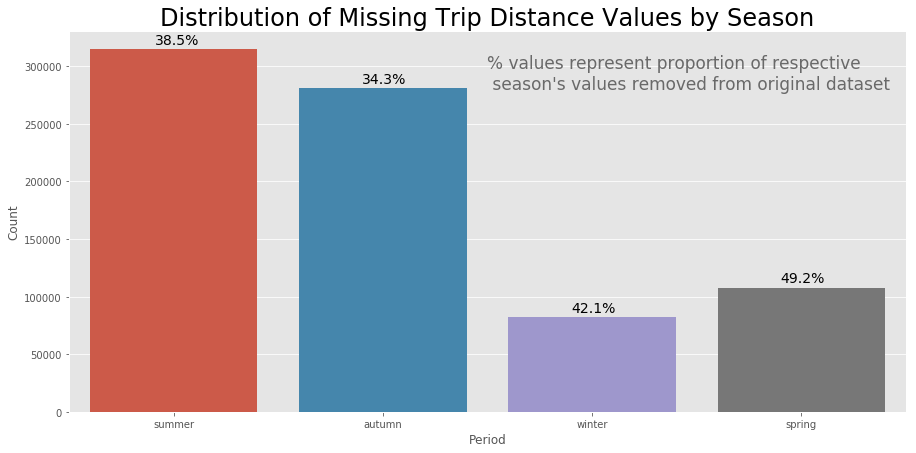

In [12]:
sns.countplot(x=missing.season)

# Calculate and plot % for what proportion of season's data is being removed, place above bin
plt.text(-0.09, len(missing[missing.season == 'summer'].index)+5000,
         "{}%".format(
             round(len(missing[missing.season == 'summer']
                       .index)*100/len(df[df.season == 'summer'].index), 1)),
        fontsize=14)

plt.text(0.9, len(missing[missing.season == 'autumn'].index)+5000,
         "{}%".format(
             round(len(missing[missing.season == 'autumn']
                       .index)*100/len(df[df.season == 'autumn'].index), 1)),
        fontsize=14)

plt.text(1.9, len(missing[missing.season == 'winter'].index)+5000,
         "{}%".format(
             round(len(missing[missing.season == 'winter']
                       .index)*100/len(df[df.season == 'winter'].index), 1)),
        fontsize=14)

plt.text(2.9, len(missing[missing.season == 'spring'].index)+5000,
         "{}%".format(
             round(len(missing[missing.season == 'spring']
                       .index)*100/len(df[df.season == 'spring'].index), 1)),
        fontsize=14)

plt.text(1.5, 280000,
"% values represent proportion of respective\n season's values removed from original dataset",
        fontsize=17, color='dimgrey')

plt.title("Distribution of Missing Trip Distance Values by Season", fontsize=24)
plt.xlabel("Period")
plt.ylabel("Count")
plt.show()

We can see how we are removing more values from trips that took place during summer and autumn, however proportionately we have not taken away as many values from those seasons. Instead, we have disproportionately taken away more values from winter and spring trips.

This is not great because there is a 15% swing in the proportion of values removed from spring and autumn data. However, there is not much we can do: spelling inconsistencies are notoriously difficult to fix, so this limitation is simply something we will have to keep in mind when doing analysis - we will still exclude trips with missing trip distance data from our analysis.

In [13]:
df = df[~df.isna().any(axis=1)]

Let's see how `season` distributes after these changes:

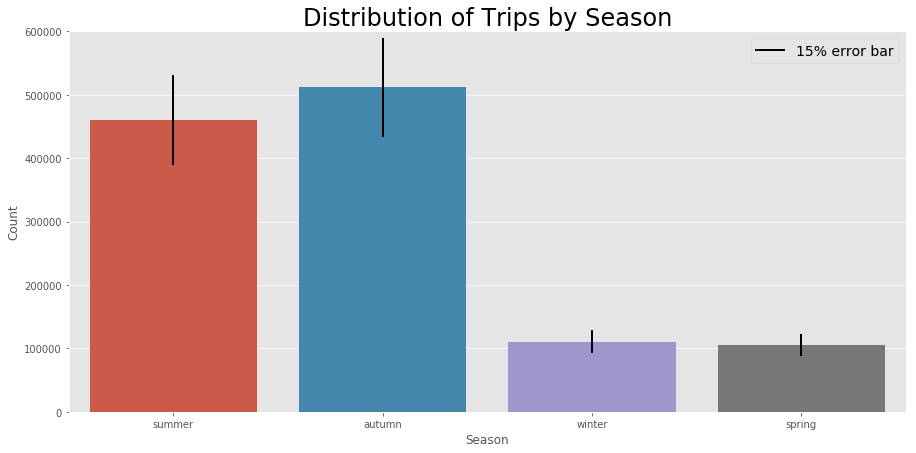

In [53]:
ax = sns.countplot(x=df.season)
ax.set_ylim([0,600000])

# Plot error bars
ax.axvline(x=0,ymin=(len(df[df.season=='summer'].index)*0.85)/ax.get_ylim()[1],
           ymax=(len(df[df.season=='summer'].index)*1.15)/ax.get_ylim()[1],
          linewidth=2, color='black', label='15% error bar')

ax.axvline(x=1,ymin=(len(df[df.season=='autumn'].index)*0.85)/ax.get_ylim()[1],
           ymax=(len(df[df.season=='autumn'].index)*1.15)/ax.get_ylim()[1],
          linewidth=2, color='black')

ax.axvline(x=2,ymin=(len(df[df.season=='winter'].index)*0.85)/ax.get_ylim()[1],
           ymax=(len(df[df.season=='winter'].index)*1.15)/ax.get_ylim()[1],
          linewidth=2, color='black')

ax.axvline(x=3,ymin=(len(df[df.season=='spring'].index)*0.85)/ax.get_ylim()[1],
           ymax=(len(df[df.season=='spring'].index)*1.15)/ax.get_ylim()[1],
          linewidth=2, color='black')

plt.title("Distribution of Trips by Season", fontsize=24)
plt.xlabel("Season")
plt.ylabel("Count")
plt.legend(fontsize=14)
plt.show()

We can see how the large majority of trips take place during summer and autumn months - this is clearly the case even when we try to account for the error we might have made previously when removing trips with missing trip distance data. We chose to display an error margin of 15% because this was the difference in the greatest and lowest proportions of values removed, for spring and autumn respectively.

### Weather Data

We will scrape the data from Canada's historical climate database for each day from July 1st 2016 to December 31st 2017 - the time period we are analysing our Bike Share data on. The data is presented in [neat tables](https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=2017&Month=1#) that are really easy and fast to go through using Pandas. We will scrape each day's mean temperature in degrees Celcius, and each day's precipitation in millimeters.

First, we will create a dictionary of the form:

```python
    {YEAR:
        {DAY: (mean_temp, precipitation)
        }
    }
```

Data is not available for all days, in which case we will input the appropriate value as NaN.

In [15]:
weather = {}

def populate_weather(year: int, from_month: int, to_month: int):
    """Queries Canada's historical climate database and populates weather
    with daily weather data for all days between from_month and to_month
    (inclusive) in the given year."""
    weather[year] = {}
    for month in range(from_month, to_month+1):
        weather[year][month] = {}

        url = 'https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year={}&Month={}#'\
              .format(year, month)
        table = pd.read_html(url)[0]

        # Iterate through table for given month
        for i, row in table.iterrows():
            # If we are no longer reading day data, but instead a row like 'total'
            if re.search("^\d{2}$", row['DAY']) is None:
                break

            # When the month's table has no unexpected values,
            # they are stored immediatelly as floats,
            # so to standardize our method, we will first cast every value as a str
            mean_temp = str(row['Mean Temp Definition°C'])
            precipitation = str(row['Total Precip Definitionmm'])

            # Check that we have data for the given day
            if re.search("\d\.\d$", mean_temp) is None:
                mean_temp = np.nan
            else:
                mean_temp = float(mean_temp)

            if re.search("\d\.\d$", precipitation) is None:
                precipitation = np.nan
            else:
                precipitation = float(precipitation)

            # Store as tuple containing mean temperature and precipitation
            weather[year][month][int(row['DAY'])] = (mean_temp, precipitation)


# Populate weather for July 1st 2016 to December 31st 2017
populate_weather(2016, 7, 12)
populate_weather(2017, 1, 12)

Then, we iterate through our entire Bike Share dataframe, and get the mean temperature and precipitation data for each trip from our lookup dictionary. We will store the mean temperature in `mean_temp` and the total precipitation in `precipitation`.

In [16]:
def get_weather_statistics(row):
    """Takes in a pandas Series representing information about a single trip, and returns
    the mean temperature and precipitation of the day the trip took place (more precisely,
    the day the trip began on)."""
    # Get the trip's year, month and day, and then look up the value in the dictionary
    year = int(row.trip_start_time.strftime('%Y'))
    month = int(row.trip_start_time.strftime('%m'))
    day = int(row.trip_start_time.strftime('%d'))
    
    if year not in weather or month not in weather[year] or day not in weather[year][month]:
        return pd.Series((np.nan, np.nan))
    
    data = weather[year][month][day]
    if len(data) != 2:
        return pd.Series((np.nan, np.nan))

    return pd.Series(data)

df[['mean_temp', 'precipitation']] = df.apply(lambda row: get_weather_statistics(row), axis=1)

Now, let's take a quick glance at how these newly created variables distribute. First, `mean_temp`:

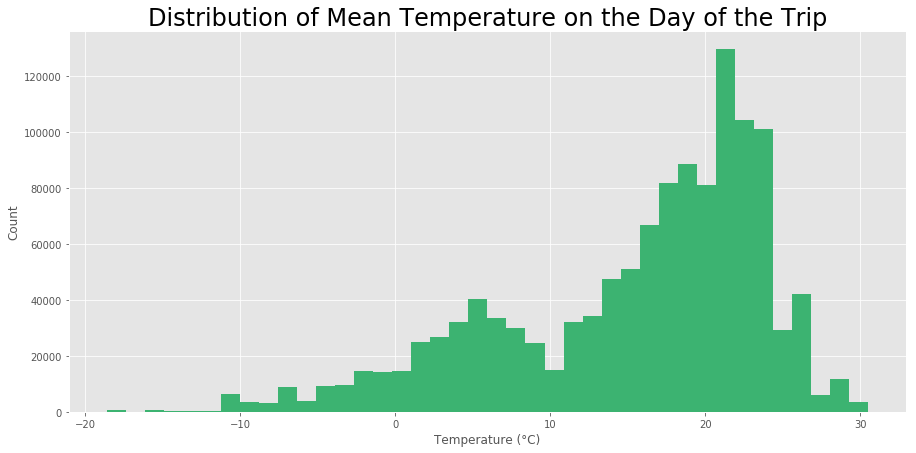

In [17]:
df['mean_temp'].hist(bins=40, color='mediumseagreen')

plt.title("Distribution of Mean Temperature on the Day of the Trip", fontsize=24)
plt.xlabel("Temperature (°C)")
plt.ylabel("Count")
plt.show()

In [18]:
desc = {"Mean Temperature on the Day of the Trip (°C)": df.mean_temp.describe().round(1)}
pd.DataFrame(desc)

Mean Temperature on the Day of the Trip (°C)
count                                     1226735.0
mean                                           15.5
std                                             8.6
min                                           -18.6
25%                                            10.4
50%                                            18.1
75%                                            21.9
max                                            30.5

We can see that the distribution has two dominant modes: one centered around 20°C, and the other around 5°C. The distribution is left-skewed with an overall mean temperature of 15.5°C.

Secondly, `precipitation`:

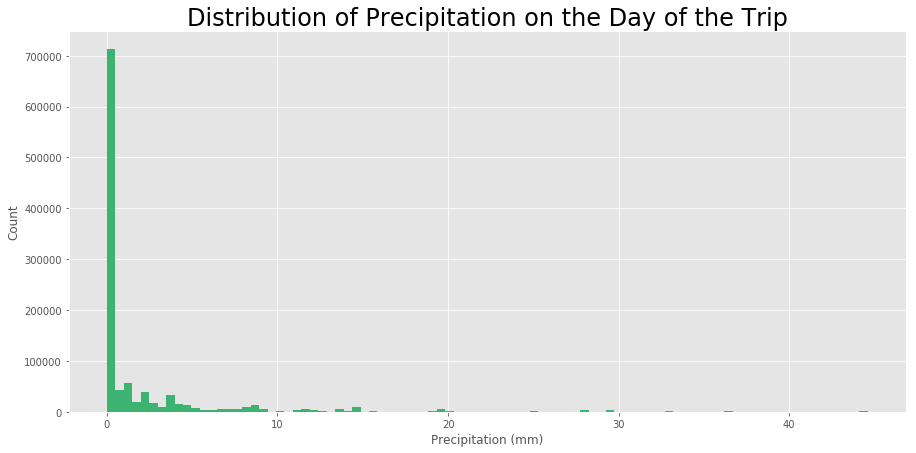

In [19]:
df['precipitation'].hist(bins=90, color='mediumseagreen')

plt.title("Distribution of Precipitation on the Day of the Trip", fontsize=24)
plt.xlabel("Precipitation (mm)")
plt.ylabel("Count")
plt.show()

In [20]:
desc = {"Precipitation on the Day of the Trip (mm)": df.precipitation.describe().round(1)}
pd.DataFrame(desc)

Precipitation on the Day of the Trip (mm)
count                                  1073240.0
mean                                         1.9
std                                          4.7
min                                          0.0
25%                                          0.0
50%                                          0.0
75%                                          1.4
max                                         44.6

We can see that over 50% of the trips have been recorded on days without precipitation. The [mean daily precipitation in Toronto is 2.18mm](https://en.climate-data.org/north-america/canada/ontario/toronto-53/), while the mean for this distribution is 1.9, suggesting that Bike Share users embark on trips more frequently on days with very little or no precipitation.

Let's take a closer look at trips that were started on days that had precipitation to get a better look at the rest of the distribution:

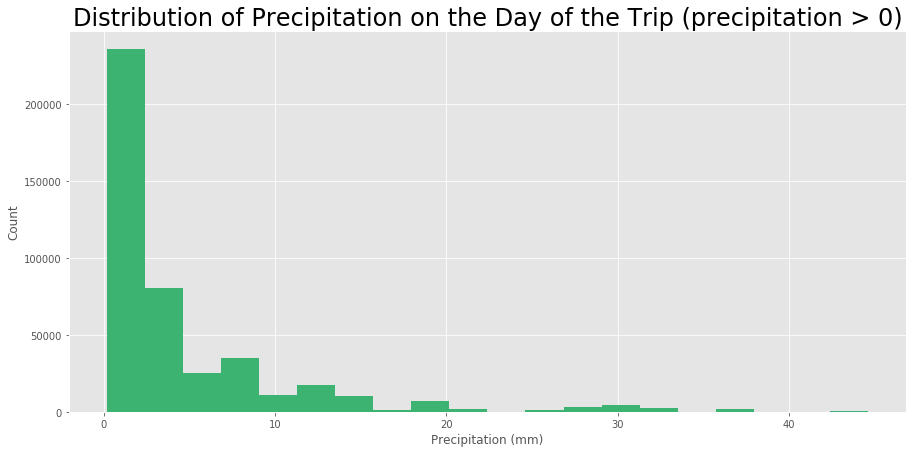

In [21]:
df.precipitation[df.precipitation > 0].hist(bins=20, color='mediumseagreen')

plt.title("Distribution of Precipitation on the Day of the Trip (precipitation > 0)", fontsize=24)
plt.xlabel("Precipitation (mm)")
plt.ylabel("Count")
plt.show()

In [22]:
desc = {"Precipitation on the Day of the Trip (mm) [precipitation > 0]": df.precipitation[df.precipitation > 0]
        .describe().round(1)}
pd.DataFrame(desc)

Precipitation on the Day of the Trip (mm) [precipitation > 0]
count                                           437747.0            
mean                                                 4.7            
std                                                  6.4            
min                                                  0.2            
25%                                                  0.6            
50%                                                  2.2            
75%                                                  5.4            
max                                                 44.6

We can see that the distribution is still very right-skewed when we remove trips on days without precipitation, further suggesting that Bike Share users prefer little or no precipitation.

# Analysis
## 1. Measuring trip 'length'

We will consider two ways to measure trip length. First, we can measure the duration of the trip in seconds by using the information in `trip_duration_seconds` that came with the original dataset.

Secondly, we can measure the distance between the trip's start and end stations 'as the crow flies'. Of course, since bikes can't fly nor go through buildings, this trajectory will likely not represent the actual path a customer took. Because we don't have any tracking data, nor do we have a simple way to figure out the most probable shortest path the customer took, this method is the best available measurement of trip distance. It is very likely that a lot of users don't simply ride from station A to station B, but instead take detours and stop in different places inbetween, too. Despite these limitations, it still gives us some sort of idea on how long the trip was.

As mentioned previously, we have coordinates data for the bike stations, so we've used the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) to compute the distance between the start and end stations in meters, and stored it in the column `trip_distance`.

Let's now dive into the data and take a look at how these two measurements distribute. First, we will look at `trip_duration_seconds`. We will immediatelly realise that this distribution has some extreme outliers, which are clearly visible on this strip plot:

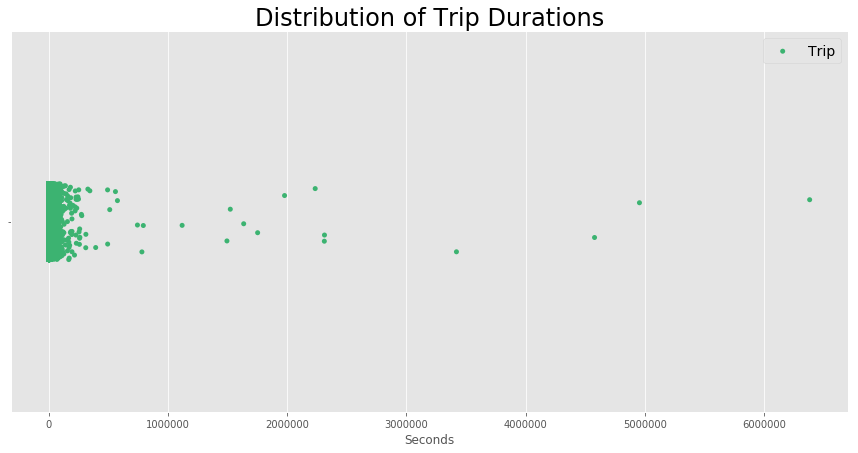

In [24]:
sns.stripplot(x=df.trip_duration_seconds, size = 5, jitter=True, label='Trip',
              color='mediumseagreen')

plt.title("Distribution of Trip Durations", fontsize=24)
plt.xlabel("Seconds")
plt.legend(fontsize=14)
plt.show()

The longest trip recorded in this dataset is nearly 72 days long - that's over 2 months! Unless Forrest Gump gave up running and decided instead to pick up biking, it is safe to say that these outliers are invalid trips. 

We will need to somehow deal with these outliers, but it is difficult to intuitively draw a hard line on how long a valid trip can be. Hence, we will use the commonly accepted definition that defines outliers as points that are at least 1.5 times the length of the inner-quartile range (IQR) away from either end of the IQR.

In [25]:
def remove_outliers(df):
    """Removes all rows for which the entry in trip_duration_seconds is more
    than 1.5 times the length of the inner quartile range (IQR) away from
    the first or third quartiles of the distribution of the trip durations."""
    
    first = df.trip_duration_seconds.quantile(0.25)
    third = df.trip_duration_seconds.quantile(0.75)
    iqr = third - first
    return df[(first - 1.5*iqr <= df.trip_duration_seconds) &
              (df.trip_duration_seconds <= third + 1.5*iqr)]

df = remove_outliers(df)

We can't say for sure that we aren't eliminating valid trips - there might be people who just decided to go on really long trips, but we have to draw a line somehow. Intuitively, we wouldn't expect anyone to use a bike for more than a short period of time, so under this assumption we won't remove many valid trips, which in return will not skew any of our later analyses. We can now take a look at how trip duration distributes:

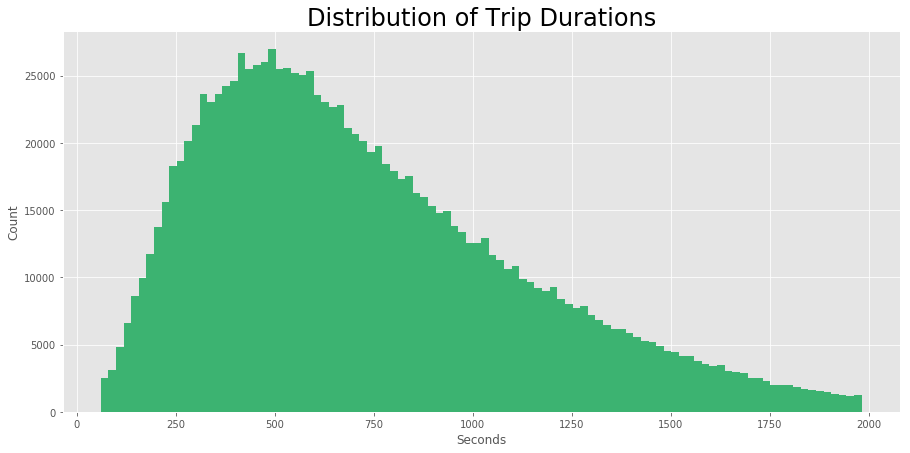

In [26]:
df.trip_duration_seconds.hist(bins=100, color='mediumseagreen')

plt.title("Distribution of Trip Durations", fontsize=24)
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

In [27]:
desc = {'Trip Duration (seconds)': df.trip_duration_seconds.describe().round(1)}
pd.DataFrame(desc)

Trip Duration (seconds)
count                1187934.0
mean                     728.6
std                      398.1
min                       60.0
25%                      423.0
50%                      650.0
75%                      969.0
max                     1982.0

After all of our data cleaning we are left with just under 1.2 million trips. We can clearly see how our changes have cut the distribution at 60 seconds, and at 1982 seconds - that is 33 minutes, which is where from onwards we consider trips to be outliers. The average trip duration is 728 seconds or just over 12 minutes. The distribution is unimodal with a mode at around 500 seconds or 8 minutes, and is right-skewed.

Now, let's take a look at `trip_distance`:

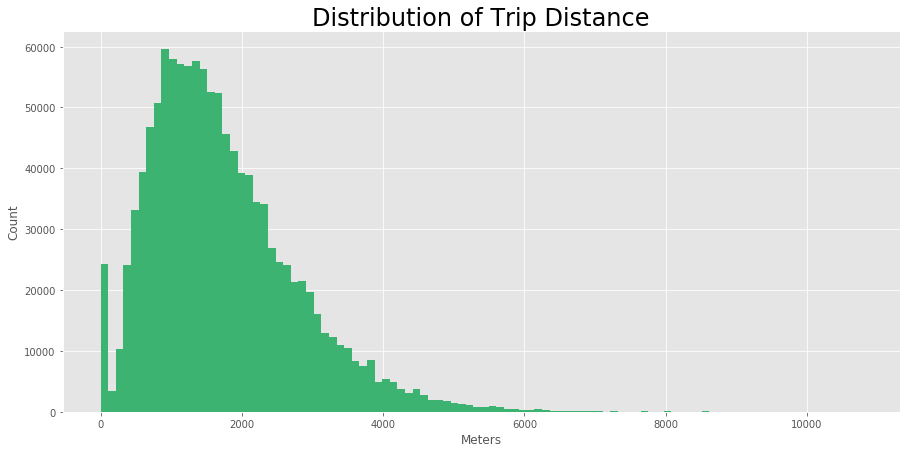

In [28]:
df.trip_distance.hist(bins=100, color='mediumseagreen')

plt.title("Distribution of Trip Distance", fontsize=24)
plt.xlabel("Meters")
plt.ylabel("Count")
plt.show()

In [29]:
desc = {'Trip Distance (meters)': df.trip_distance.describe().round(1)}
pd.DataFrame(desc)

Trip Distance (meters)
count               1187934.0
mean                   1728.3
std                    1030.8
min                       0.0
25%                     977.9
50%                    1540.2
75%                    2286.7
max                   10773.6

In terms of shape, we can immediately see that this distribution is similar to trip duration's distribution - it is also unimodal and right-skewed. Another interesting thing to notice is the outsticking high bin on the very left - this represents the trips which started and ended at the same station. As suggested earlier, we can now fairly safely say that there are valid round trips starting and beginning at the same station as we've done our best to remove any invalid entries. Similarly, it is interesting to see how the longest trip has been at least 10.7 kilometers long (recall that this is only the straight line distance).

We can look at the relationship between our two measurements of trip length. As one would expect, it takes a longer amount of time to cover a longer distance. However, as has been mentioned on numerous occasions already, there are many things we can't see from just the start and end stations - were there any stops or detours inbetween, or did the rider take the optimal path. Let's visualize our two definitions of trip length on a scatterplot:

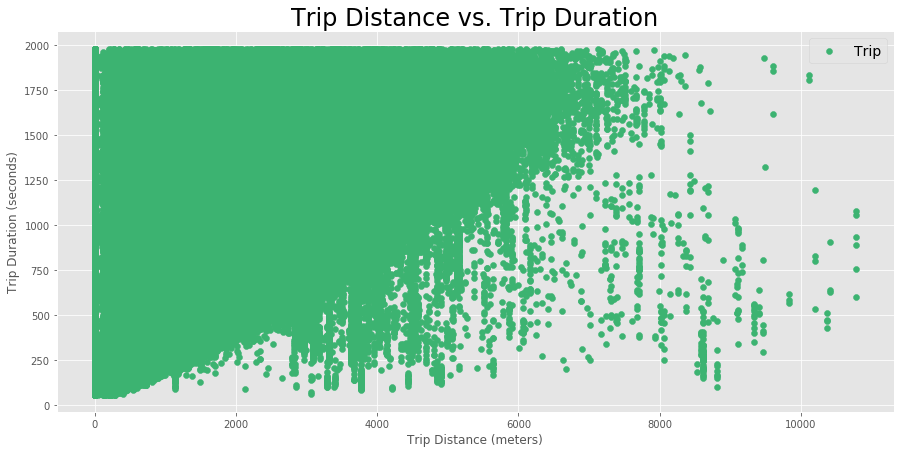

In [30]:
fig, ax = plt.subplots()

ax.scatter(x=df.trip_distance, y=df.trip_duration_seconds,
           color='mediumseagreen', label='Trip')

plt.title("Trip Distance vs. Trip Duration", fontsize=24)
plt.xlabel("Trip Distance (meters)")
plt.ylabel("Trip Duration (seconds)")
plt.legend(loc='upper right', fontsize=14)
plt.show()

Boy, what a mess, but an interesting one! To get a better idea of what's going on, let's pair this graph with the exact same one, but let's make every dot partially transparent to better visualize the clustering.

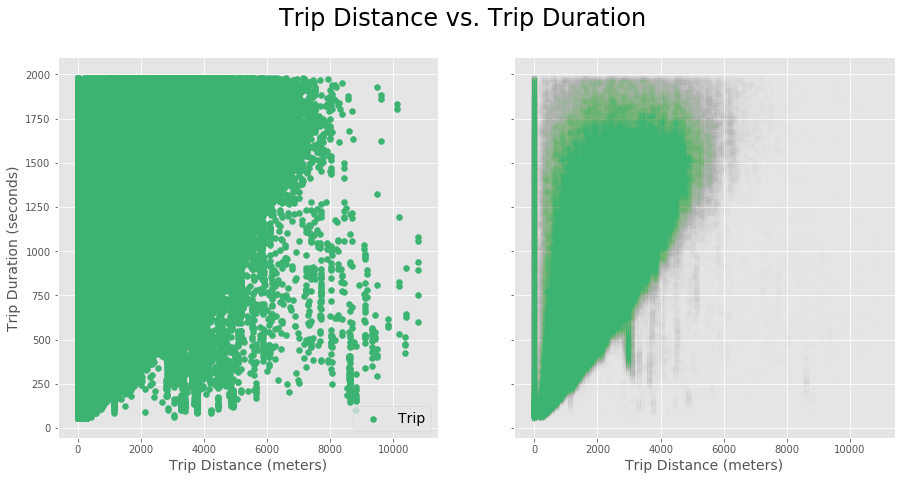

In [31]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].scatter(x=df.trip_distance, y=df.trip_duration_seconds,
              color='mediumseagreen', label = 'Trip')
ax[1].scatter(x=df.trip_distance, y=df.trip_duration_seconds,
              color='mediumseagreen', alpha=0.002)

plt.suptitle("Trip Distance vs. Trip Duration", fontsize=24)
ax[0].set_xlabel("Trip Distance (meters)", fontsize=14)
ax[1].set_xlabel("Trip Distance (meters)", fontsize=14)
ax[0].set_ylabel("Trip Duration (seconds)", fontsize=14)
ax[0].legend(loc='lower right', fontsize=14)
plt.show()

We can see how the data has, as expected, a lot of variance, but still we can notice a sort of exponential relationship between trip distance and duration, which matches intuition: on longer trips people become tired and so can't cycle as fast and may have to take breaks or slow down. We can again notice the trips starting and ending at the same station and see that people go on trips of very various durations of such type.

There's a very interesting outsticking cluster of trips around the 3000 meter - 500 second mark. Perhaps this is the effect of a popular route between two stations: users travel between these two stations often and with the same average time, causing it to appear on this visualization. We will have to investigate this further.

Once again we realise that there are anomalies in the data: notice some of the outliers in the bottom right corner. Some of these trips show as having completed around 10 000 meters in 500 seconds: that amounts to an average speed of 72 km/h - that is absolutely inhumane. [The fastest recorded cycling speed in an upright position is 82 km/h](https://en.wikipedia.org/wiki/Bicycle_performance#Typical_speeds) and that is only over a distance of 200 meters, while the [fastest Tour de France time set by Lance Armstrong was achieved with an average speed of 41 km/h](https://www.cyclingweekly.com/news/racing/tour-de-france/fast-tour-de-france-useless-stats-429620), and well, he had some extra help to achieve that, too.

Again, we would like to eliminate these outliers, but drawing a hard line is difficult to do. We can't use the 'IQR trick' on trip speed this time because, as previously explained, there are many reasons why the distance travelled may not represent the true value, and so trip speed is affected too. So, we are going to choose a fixed value based on the examples provided previously: we will remove any trips with an average speed over 40 km/h. While it is entirely possible that someone was in that much of a hurry, we are dealing with city bike data, and so it's reasonable to expect such trips to be invalid. When we graph our cutoff line, we see that we aren't removing any trips in the main cluster of the data:

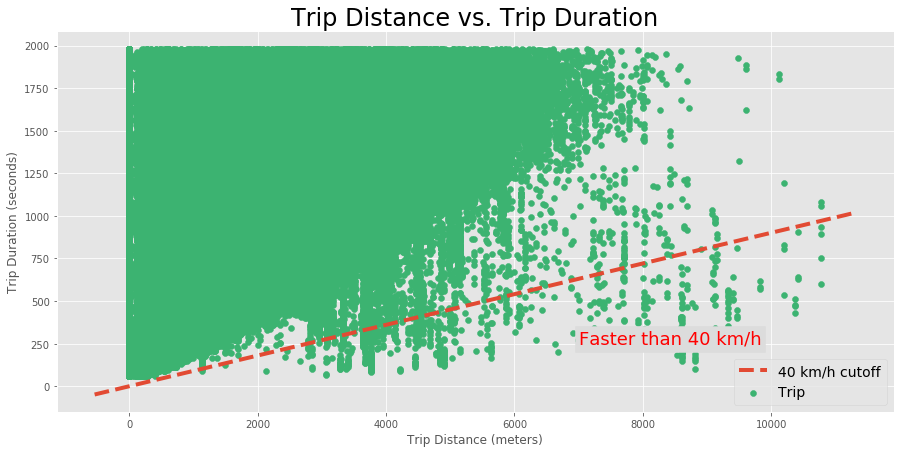

In [32]:
fig, ax = plt.subplots()

ax.scatter(x=df.trip_distance, y=df.trip_duration_seconds,
           color='mediumseagreen', label="Trip")

# Generate points to plot assuming a speed of 40 km/h = 11.1 m/s
x_vals = np.array(ax.get_xlim())
y_vals = 1/11.1 * x_vals
ax.plot(x_vals, y_vals, '--', linewidth = 4, label = '40 km/h cutoff')

ax.text(7000, 250, "Faster than 40 km/h", color='red', size=18,
        backgroundcolor='gainsboro')

plt.title("Trip Distance vs. Trip Duration", fontsize=24)
plt.xlabel("Trip Distance (meters)")
plt.ylabel("Trip Duration (seconds)")
plt.legend(fontsize=14, loc='lower right')
plt.show()

In [33]:
df = df[df.trip_distance/df.trip_duration_seconds <= 11.1]

Let's also investigate the outsticking small cluster of outliers that we noticed on the transparent scatterplot. Let's restrict ourselves to trips that had a distance between 2000 and 4000 meters, and a duration between 250 and 600 seconds, roughly outlining the range of the cluster. Then, let's see which stations are most popular for trips matching this criteria.

In [34]:
temp = df[(df.trip_distance >= 2000) & (df.trip_distance <= 4000) & 
          (df.trip_duration_seconds >= 250) & (df.trip_duration_seconds <= 600)]

print("In total, there are {} trips matching this criterion."
      .format(len(temp.index)))

def most_popular_stations(df, n):
    """Returns the <n> most popular stations for the given dataframe <df>
    along with the number of times they've been visited. Popularity is
    calculated based on how many trips have started or ended at a station,
    i.e. how many times a station has been visited."""
    
    start_count = df['from_station_name'].value_counts()
    end_count = df['to_station_name'].value_counts()
    return start_count.add(end_count, fill_value=0).sort_values(ascending=False).head(n)

most_popular_stations(temp, 3)

In total, there are 16690 trips matching this criterion.


161 Bleecker St (South of Wellesley)    2622.0
York St / Queens Quay W                 1413.0
Union Station                           1179.0
dtype: float64

Above are shown the 3 most visited stations matching our criterion. Namely, these are the top 3 stations where such trips were started or ended at, with the corresponding trip count values also visible. Together, trips starting or ending at these 3 stations make up about a third of all trips matching our criterion.

First, let's compute the distances between these stations:

In [35]:
stats = ['161 Bleecker St (South of Wellesley)',
         'York St / Queens Quay W', 'Union Station']
coords = [coordinates[stat] for stat in stats]
distances = {}
for i in range(3):
    distances[stats[i]] = [round(haversine(coords[i], coords[j],
                                           'm')) for j in range(3)]
    
pd.DataFrame(distances, index=stats)

161 Bleecker St (South of Wellesley)  \
161 Bleecker St (South of Wellesley)                                     0   
York St / Queens Quay W                                               2959   
Union Station                                                         2363   

                                      York St / Queens Quay W  Union Station  
161 Bleecker St (South of Wellesley)                     2959           2363  
York St / Queens Quay W                                     0            609  
Union Station                                             609              0

Above is shown a matrix of the distances in meters between all of our 3 stations. There are two station pairs that match our criterion: **York St / Queens Quay W - 161 Bleecker St (South of Wellesley)** and **Union Station - 161 Bleecker St (South of Wellesley)**.

For these two pairs of stations, let's look at all trips that were completed between these pairs, and compute statistics about the duration of such trips:

In [36]:
p1 = ['161 Bleecker St (South of Wellesley)',
      'York St / Queens Quay W']
p2 = ['161 Bleecker St (South of Wellesley)',
      'Union Station']

# Note that we are excluding trips that started and ended at the same station
pair1 = df[(df.from_station_name.isin(p1)) & (df.to_station_name.isin(p1)) &
           (df.trip_distance != 0)]
d = {'Trips between 161 Bleecker St and York St / Queens Quay W':
     pair1.trip_duration_seconds.describe().round()}
pd.DataFrame(d)

Trips between 161 Bleecker St and York St / Queens Quay W
count                                             1542.0        
mean                                               621.0        
std                                                339.0        
min                                                281.0        
25%                                                429.0        
50%                                                486.0        
75%                                                630.0        
max                                               1978.0

In [37]:
pair2 = df[(df.from_station_name.isin(p2)) &
           (df.to_station_name.isin(p2)) & (df.trip_distance != 0)]
g = {'Trips between 161 Bleecker St and Union Station':
     pair2.trip_duration_seconds.describe().round()}
pd.DataFrame(g)

Trips between 161 Bleecker St and Union Station
count                                            139.0
mean                                             951.0
std                                              339.0
min                                              472.0
25%                                              697.0
50%                                              839.0
75%                                             1100.0
max                                             1929.0

It appears that a popular route between 161 Bleecker St. and York St. / Queens Quay W seems to be the main culprit behind the curious outsticking cluster of trips: nearly 3/4 such trips have a duration in the range of 250 to 600 seconds. There are some few trips between 161 Bleecker St. and Union Station that contribute to the cluster, but most trips between this pair of stations are longer than 600 seconds in duration.

If we take another look at the transparent scatterplot where we first discovered this cluster of trips, we can see that trips in that cluster had a faster average speed than most trips. The next natural thing to ask is "Why is this so?", however it is a difficult question to answer with the data we have available. Perhaps the route between these two stations has great infrastructure or little traffic, or perhaps this is a very popular commute route, so people don't have time to waste when biking from work to home or the other way around.

Keep in mind, though, that our original (but roughly defined) query into the data gave us nearly 17 000 trips that were between 2000 and 4000 meters in distance, and 250 and 600 seconds in duration. This range captures a fair bit more than that small cluster, but it is still possible that this popular route we discovered, with just 1 500 trips recorded, is not the only reason behind it existing.

## 2. Casual user vs. member behaviour

We will compare how both of our trip length definitions differ when looking at either casual users or members. By casual users we mean customers who purchased a temporary pass to use a bike, rather than purchasing a long-term membership. First, let's consider trip duration, stored in `trip_duration_seconds`.

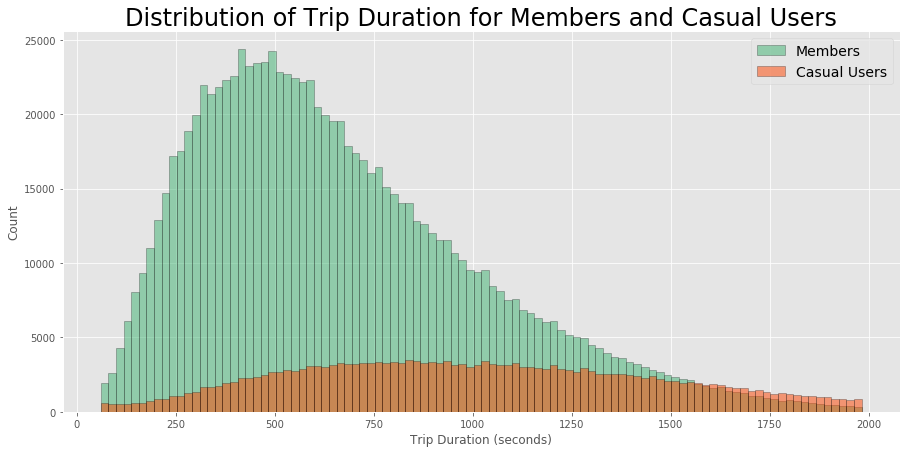

In [38]:
plt.hist(df[df.user_type == 'Member']['trip_duration_seconds'],
         bins=100, alpha=0.5, edgecolor='black',
        color='mediumseagreen', label='Members')    
plt.hist(df[df.user_type == 'Casual']['trip_duration_seconds'],
         bins=100, alpha=0.5, edgecolor='black',
        color='orangered', label='Casual Users')

plt.title("Distribution of Trip Duration for Members and Casual Users",
          fontsize=24)
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Count")
plt.legend(fontsize=14)
plt.show()

In [39]:
desc = {'Members': df[df.user_type == 'Member']['trip_duration_seconds']
        .describe().round(1),
        'Casual users': df[df.user_type == 'Casual']['trip_duration_seconds']
        .describe().round(1)}
pd.DataFrame(desc)

Members  Casual users
count  966135.0      221092.0
mean      666.0        1003.4
std       358.4         443.7
min        60.0          60.0
25%       395.0         658.0
50%       596.0         980.0
75%       874.0        1335.0
max      1982.0        1982.0

The first obvious observation is that the vast majority of trips are made by members. Thus, as would make sense, the shape of the distribution for members looks to be identical to the overall distribution of trip duration that we saw earlier. However, the distribution for non-members is completely different.

The distribution for casual users is fairly symmetrical, with a mean of 1003 seconds or 17 minutes, 50% more than the mean for members. We can notice how very long trips are more common among casual users, which is surprising considering we have more than 4 times the data for members.

Similarly, let's take a look at trip distance:

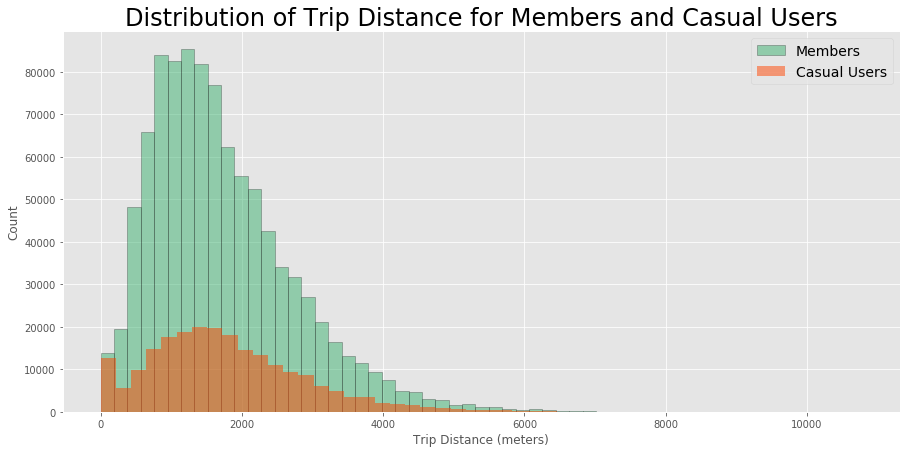

In [40]:
plt.hist(df[df.user_type == 'Member']['trip_distance'],
         bins=50, alpha=0.5, edgecolor='black',
        color='mediumseagreen', label='Members')    
plt.hist(df[df.user_type == 'Casual']['trip_distance'],
         bins=50, alpha=0.5,
        color='orangered', label='Casual Users')

plt.title("Distribution of Trip Distance for Members and Casual Users",
          fontsize=24)
plt.xlabel("Trip Distance (meters)")
plt.ylabel("Count")
plt.legend(fontsize=14)
plt.show()

In [41]:
desc = {'Members': df[df.user_type == 'Member']['trip_distance']
        .describe().round(1),
        'Casual users': df[df.user_type == 'Casual']['trip_distance']
        .describe().round(1)}
pd.DataFrame(desc)

Members  Casual users
count  966135.0      221092.0
mean     1714.4        1777.0
std      1010.3        1090.0
min         0.0           0.0
25%       974.5        1014.7
50%      1520.4        1635.4
75%      2260.0        2394.8
max      9477.0       10773.6

This time we can see that the distributions for members and casual users have a very similar shape, and resemble the shape of the overall distribution for trip distance. Interestingly enough, casual users nearly match members in the number of trips that start and end at the same stop despite there being over 4 times fewer trips recorded by casual users.

Because the distributions for members and casual users were so different for trip duration, but similar for trip distance, we would expect casual users to have slower trip speeds. Let's turn to the already familiar scatterplots we saw to investigate:

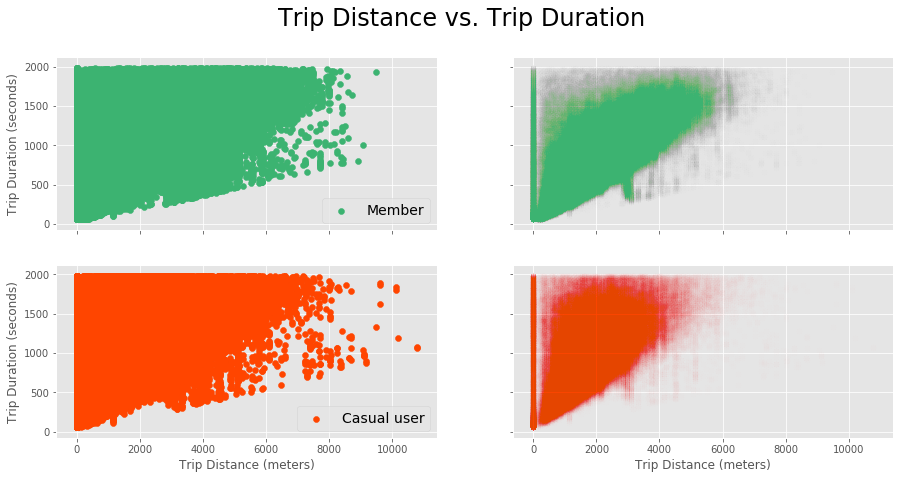

In [42]:
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)

ax[0][0].scatter(x=df[df.user_type == 'Member']['trip_distance'],
                 y=df[df.user_type =='Member']['trip_duration_seconds'],
              color='mediumseagreen', label='Member')
ax[1][0].scatter(x=df[df.user_type == 'Casual']['trip_distance'],
                 y=df[df.user_type =='Casual']['trip_duration_seconds'],
              color='orangered', label='Casual user')
ax[0][1].scatter(x=df[df.user_type == 'Member']['trip_distance'],
                 y=df[df.user_type =='Member']['trip_duration_seconds'],
              color='mediumseagreen', alpha=0.002)
ax[1][1].scatter(x=df[df.user_type == 'Casual']['trip_distance'],
                 y=df[df.user_type =='Casual']['trip_duration_seconds'],
              color='orangered', alpha=0.002)

plt.suptitle("Trip Distance vs. Trip Duration", fontsize=24)
ax[1][0].set_xlabel("Trip Distance (meters)")
ax[1][1].set_xlabel("Trip Distance (meters)")
ax[0][0].set_ylabel("Trip Duration (seconds)")
ax[1][0].set_ylabel("Trip Duration (seconds)")
ax[0][0].legend(fontsize=14)
ax[1][0].legend(fontsize=14)
plt.show()

As hypothesized, casual users seem to have a lower average speed as the main cluster of points representing trips is more towards the top left corner of the graph - less distance covered in greater time. We can also notice how casual users have more extreme outliers compared to members: this is caused by long distance trips being more common among casual users, as we saw before. Again, we can see on both density graphs how there are trips starting and ending at the same time with very various durations.

## 3. Effects of the present season and weather conditions on trip length

In this part we will analyze what sort of effect, if any, do the season and weather have on our two definitions of trip length. To start off, let's look at the effects season has.

Recall that we defined the season the trip took place in based on the trip's month, and stored it in the column `season`. During the data cleaning process we noticed how we removed a disproportionate amount of trips from winter and spring data. Let's first see how trip duration distributes per season:

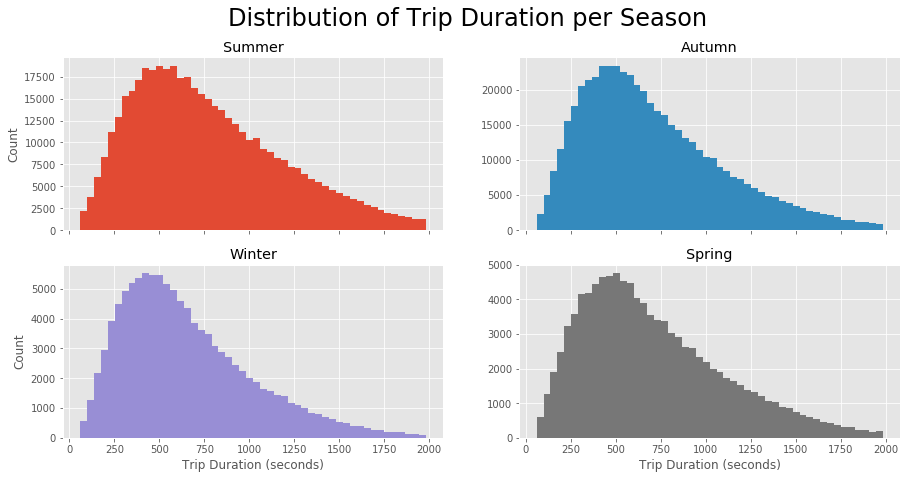

In [43]:
fig, ax = plt.subplots(2,2, sharex=True)

ax[0][0].hist(df[df.season=='summer']['trip_duration_seconds'],
              bins=50)
ax[0][1].hist(df[df.season=='autumn']['trip_duration_seconds'],
              bins=50, color='C1')
ax[1][0].hist(df[df.season=='winter']['trip_duration_seconds'],
              bins=50, color='C2')
ax[1][1].hist(df[df.season=='spring']['trip_duration_seconds'],
              bins=50, color='C3')

ax[0][0].set_title("Summer")
ax[0][1].set_title("Autumn")
ax[1][0].set_title("Winter")
ax[1][1].set_title("Spring")

plt.suptitle("Distribution of Trip Duration per Season",
             fontsize=24)
ax[0][0].set_ylabel("Count")
ax[1][0].set_ylabel("Count")
ax[1][0].set_xlabel("Trip Duration (seconds)")
ax[1][1].set_xlabel("Trip Duration (seconds)")
plt.show()

In [44]:
desc = {'Summer': df[df.season == 'summer']['trip_duration_seconds']
        .describe().round(1),
        'Autumn': df[df.season == 'autumn']['trip_duration_seconds']
        .describe().round(1),
       'Winter': df[df.season == 'winter']['trip_duration_seconds']
        .describe().round(1),
       'Spring': df[df.season == 'spring']['trip_duration_seconds']
        .describe().round(1)}
pd.DataFrame(desc)

Summer    Autumn    Winter    Spring
count  460595.0  511534.0  110454.0  104644.0
mean      773.4     708.3     655.8     710.1
std       412.2     388.9     362.7     393.6
min        60.0      60.0      60.0      60.0
25%       453.0     412.0     382.0     409.0
50%       699.0     629.0     580.0     630.0
75%      1036.0     937.0     861.0     947.0
max      1982.0    1982.0    1982.0    1982.0

The shapes of the distribution for each season are nearly identical. Notice, though, that we are using a unique y-axis for each graph, while keeping the same x-axis throughout.

We can still see that the season does to some extent affect trip duration: the mean trip duration during winter is 656 seconds, or 11 minutes, while the mean for summer is 773 seconds, or 13 minutes. We cannot say for sure that this is a significant difference, it may just be caused by the specific data we happen to have. Recall also that we removed proportionately more values from winter and spring. If we had kept those records, we could potentially have more similar statistics across all seasons.

Let's also take a look at trip distance:

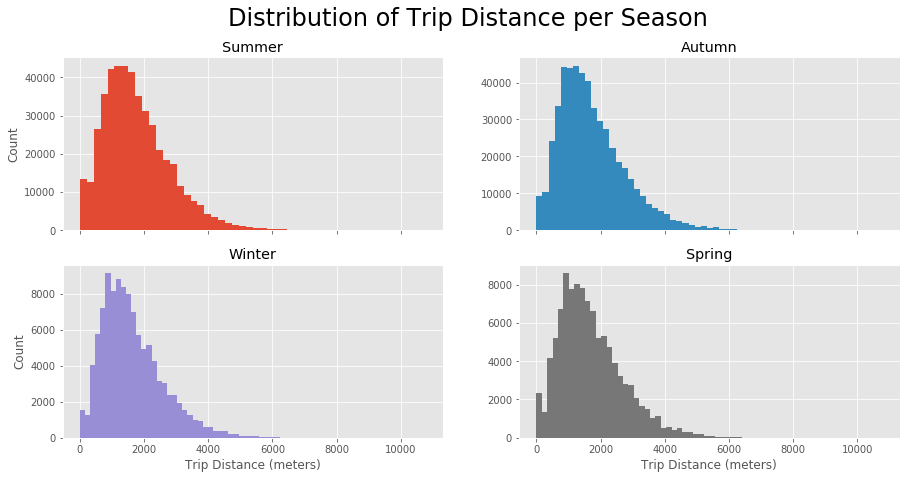

In [45]:
fig, ax = plt.subplots(2,2, sharex=True)

ax[0][0].hist(df[df.season=='summer']['trip_distance'],
              bins=50)
ax[0][1].hist(df[df.season=='autumn']['trip_distance'],
              bins=50, color='C1')
ax[1][0].hist(df[df.season=='winter']['trip_distance'],
              bins=50, color='C2')
ax[1][1].hist(df[df.season=='spring']['trip_distance'],
              bins=50, color='C3')

ax[0][0].set_title("Summer")
ax[0][1].set_title("Autumn")
ax[1][0].set_title("Winter")
ax[1][1].set_title("Spring")

plt.suptitle("Distribution of Trip Distance per Season", fontsize=24)
ax[0][0].set_ylabel("Count")
ax[1][0].set_ylabel("Count")
ax[1][0].set_xlabel("Trip Distance (meters)")
ax[1][1].set_xlabel("Trip Distance (meters)")
plt.show()

In [46]:
desc = {'Summer': df[df.season == 'summer']['trip_distance']
        .describe().round(1),
        'Autumn': df[df.season == 'autumn']['trip_distance']
        .describe().round(1),
       'Winter': df[df.season == 'winter']['trip_distance']
        .describe().round(1),
       'Spring': df[df.season == 'spring']['trip_distance']
        .describe().round(1)}
pd.DataFrame(desc)

Summer    Autumn    Winter    Spring
count  460595.0  511534.0  110454.0  104644.0
mean     1750.3    1727.4    1640.7    1702.8
std      1038.6    1031.5     960.6    1003.2
min         0.0       0.0       0.0       0.0
25%       997.2     977.4     932.9     954.2
50%      1577.3    1527.2    1454.8    1524.9
75%      2318.5    2278.1    2159.6    2272.4
max     10773.6    9477.0    7979.8    8423.3

Again, we do not notice any significant differences between the distributions, but we can still see that trips are on average shorter during winter and spring compared to summer and autumn, though not by much. Looking at the 3rd quartile and maximum values, we can observe how very long trips are more frequent during summer and autumn months.

As has become tradition, we can take a peek at whether there's a difference in the average speed of trips across the seasons:

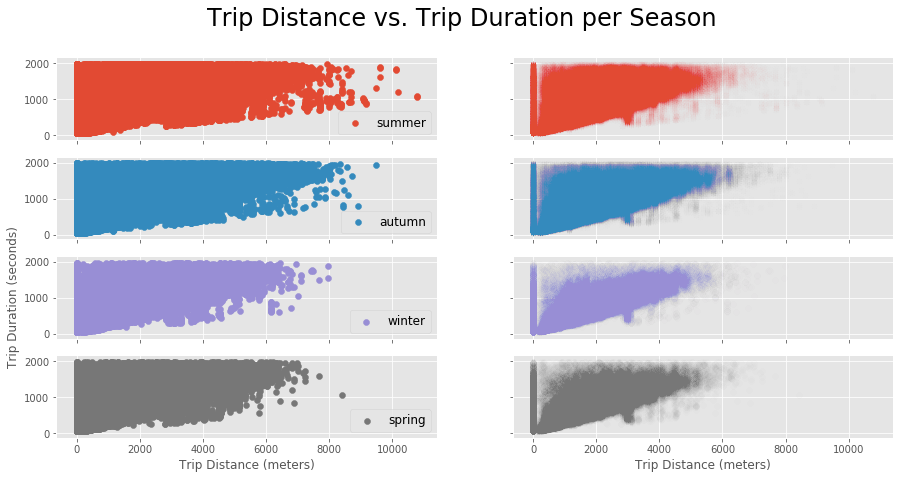

In [47]:
seasons = ['summer', 'autumn', 'winter', 'spring']
# Since there are approximately 5 times more observations in summer
# and autumn, we will scale the transparency of the scatterplots
# appropriately
alphas=[0.002, 0.002, 0.01, 0.01]

fig, ax = plt.subplots(4,2, sharey=True, sharex=True)

for i in range(4):
    ax[i][0].scatter(x=df[df.season == seasons[i]]['trip_distance'],
                     y=df[df.season==seasons[i]]['trip_duration_seconds'],
                    color = 'C{}'.format(i), label=seasons[i])
    ax[i][1].scatter(x=df[df.season == seasons[i]]['trip_distance'],
                    y = df[df.season==seasons[i]]['trip_duration_seconds'],
                    color = 'C{}'.format(i), label=seasons[i], alpha=alphas[i])


    
plt.suptitle("Trip Distance vs. Trip Duration per Season", fontsize=24)
ax[3][0].set_xlabel("Trip Distance (meters)")
ax[3][1].set_xlabel("Trip Distance (meters)")
ax[2][0].set_ylabel("Trip Duration (seconds)")
ax[0][0].legend(fontsize=12, loc='lower right')
ax[1][0].legend(fontsize=12, loc='lower right')
ax[2][0].legend(fontsize=12, loc='lower right')
ax[3][0].legend(fontsize=12, loc='lower right')
plt.show()

Since the distributions for trip duration and distance were very similar across all seasons, it is no surprise that their relationships are also similar. Still, we can once more notice how long distance trips are more common during summer and autumn. Trips starting and ending at the same station is a phenomenon that can be observed during all seasons.

In the scatterplots with transparent points we have adjusted the transparency of points to account for the differences in the number of observations per season: namely, we have made the points on the winter and spring plots 5 times more opaque as there are approximately 5 times fewer points on those plots compared to summer and autumn. So it might seem as if trips with very slow average speeds are less common during winter and spring. However, it is also possible that this is just an effect of how we decided to choose the transparency despite our best efforts to make it as fair as possible.

Now, let's dive into the weather data. Recall that we have columns `mean_temp`, representing the mean temperature in degrees Celcius of the day the trip took place, and `precipitation`, representing whether there was any precipitation on the day of the trip. First, let's look at how these two dimensions affect trip duration.

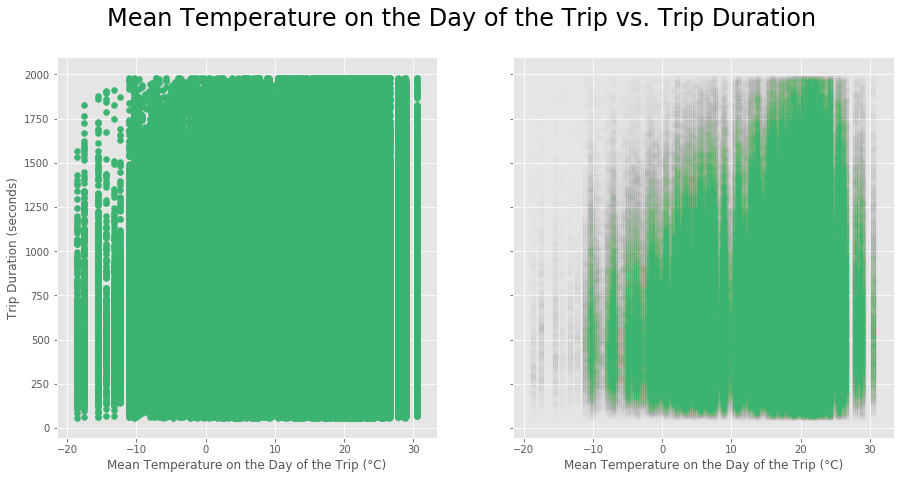

In [48]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].scatter(x=df.mean_temp, y=df.trip_duration_seconds,
              color='mediumseagreen')
ax[1].scatter(x=df.mean_temp, y=df.trip_duration_seconds,
              alpha=0.002, color='mediumseagreen')

plt.suptitle("Mean Temperature on the Day of the Trip vs. Trip Duration",
             fontsize=24)
ax[0].set_xlabel("Mean Temperature on the Day of the Trip (°C)")
ax[1].set_xlabel("Mean Temperature on the Day of the Trip (°C)")
ax[0].set_ylabel("Trip Duration (seconds)")
plt.show()

We can immediatelly notice how trips are much shorter during days with a very low mean temperature. As the daily mean temperature increases, so do trip durations, until around 25°C, where trip durations start dropping again. 

Recall how when we plotted the countwise distribution of trips' daily mean temperature, we saw a distribution with two dominant modes: one centered around 5°C and the other around 20°C. The same bimodality can be noticed on the right graph: long duration trips become more frequent at around 5°C, but then drop until around 10°C only to rise again until 20°C. There are two possible explanations for this phenomenon: either it is just a cause of how the underlying data for trips' daily mean temperature distributes and hence makes those temperature ranges seem more dominant, or Bike Share users have both two 'favourite' temperature ranges to ride a bike, and also embark on longer journeys during such days.

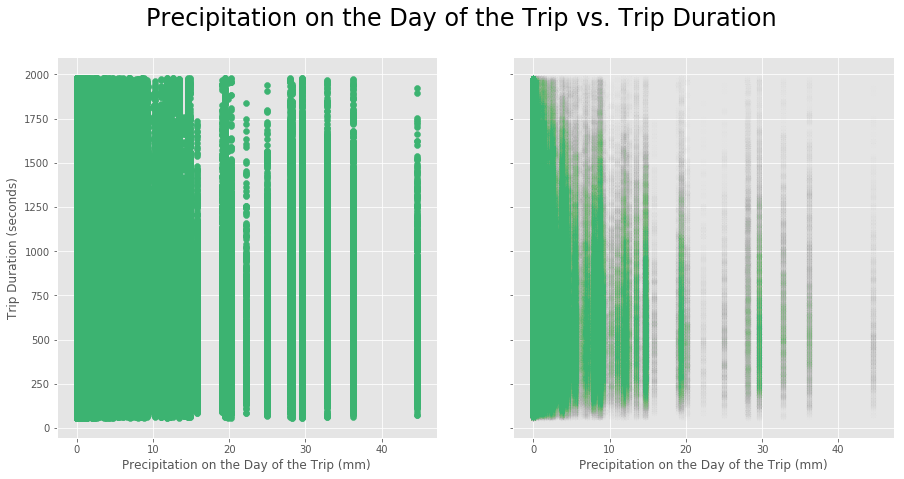

In [49]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].scatter(x=df.precipitation, y=df.trip_duration_seconds,
              color='mediumseagreen')
ax[1].scatter(x=df.precipitation, y=df.trip_duration_seconds,
              alpha=0.002, color='mediumseagreen')

plt.suptitle("Precipitation on the Day of the Trip vs. Trip Duration",
             fontsize=24)
ax[0].set_xlabel("Precipitation on the Day of the Trip (mm)")
ax[1].set_xlabel("Precipitation on the Day of the Trip (mm)")
ax[0].set_ylabel("Trip Duration (seconds)")
plt.show()

Just like for mean temperature we can observe how trips are much less frequent on days with precipitation, i.e. days that are generally considered 'less pleasant'. However, with mean temperature we could see how there were very few trips with long durations on days where there were overall few trips, but this is not the case for precipitation: there are still plenty of trips with long durations on days where there was lots of precipitation and not as many trips overall. 

Hence, it seems like the day's mean temperature has a greater effect on trip duration than precipitation. Intuitively, it certainly makes sense: we are looking at weather data for an entire day - mean temperature is something that describes an average of the day, but precipitation is a total value for the day. If it rains a lot on one day for a couple of hours, but the rest of the day is rain free, it may not have that much of an effect on ridership. 



Now, a look at trip distance:

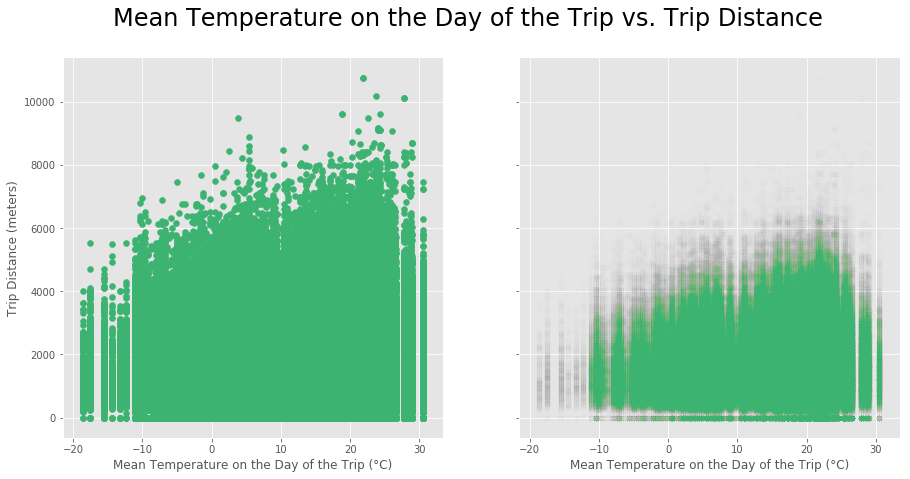

In [50]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].scatter(x=df.mean_temp, y=df.trip_distance,
              color='mediumseagreen')
ax[1].scatter(x=df.mean_temp, y=df.trip_distance,
              alpha=0.002, color='mediumseagreen')

plt.suptitle("Mean Temperature on the Day of the Trip vs. Trip Distance",
             fontsize=24)
ax[0].set_xlabel("Mean Temperature on the Day of the Trip (°C)")
ax[1].set_xlabel("Mean Temperature on the Day of the Trip (°C)")
ax[0].set_ylabel("Trip Distance (meters)")
plt.show()

These results are similar to what we saw for trip duration: generally, trip distance and the trip's day mean temperature have a positive association. We can again notice the two modes centered around 5°C and 20°C, leaving us with the same two possible explanations as before. Because we observed this when looking at both trip distance and trip duration, it appears to be more likely that this phenomenon is caused by how trip frequency distributes depending on the trip's day mean temperature, rather than temperature or precipitation having a direct impact on duration and distance.

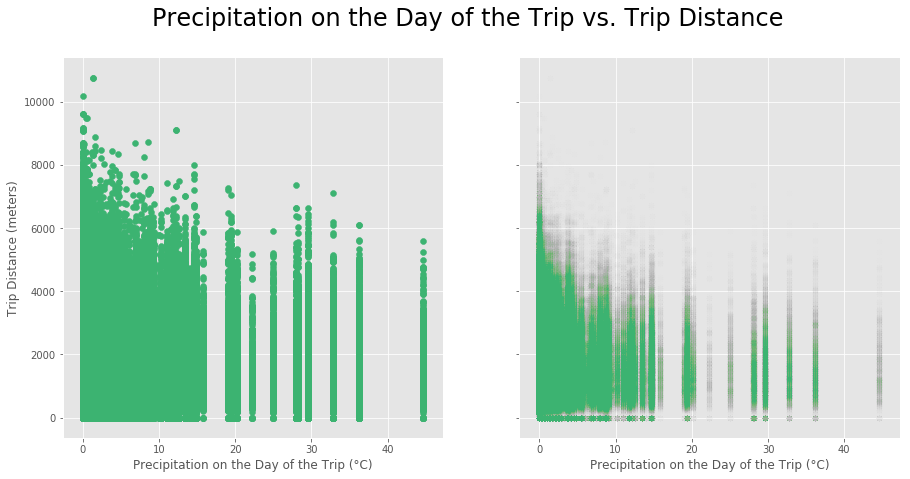

In [51]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)

ax[0].scatter(x=df.precipitation, y=df.trip_distance,
              color='mediumseagreen')
ax[1].scatter(x=df.precipitation, y=df.trip_distance,
              alpha=0.002, color='mediumseagreen')

plt.suptitle("Precipitation on the Day of the Trip vs. Trip Distance",
             fontsize=24)
ax[0].set_xlabel("Precipitation on the Day of the Trip (°C)")
ax[1].set_xlabel("Precipitation on the Day of the Trip (°C)")
ax[0].set_ylabel("Trip Distance (meters)")
plt.show()

We can notice an immediate drop in trip distance when moving from days with no or extremely little precipitation to days with moderate amounts. When we were looking at how precipitation affects trip duration, we saw that trips with long durations were still common on days with lots of precipitation - this is not the case for trip distance: trips of all distances follow the overall tendency to decrease as precipitation increases.

In the above discussion we did not really give a definitive answer on whether mean temperature and precipitation had an effect on trip duration and distance. To give us a better idea of what's going on, let's compute the correlation coefficient between our columns of interest: `trip_duration_seconds`, `trip_distance`, `mean_temp`, and `precipitation`. We can display our results in this neat correlation matrix:

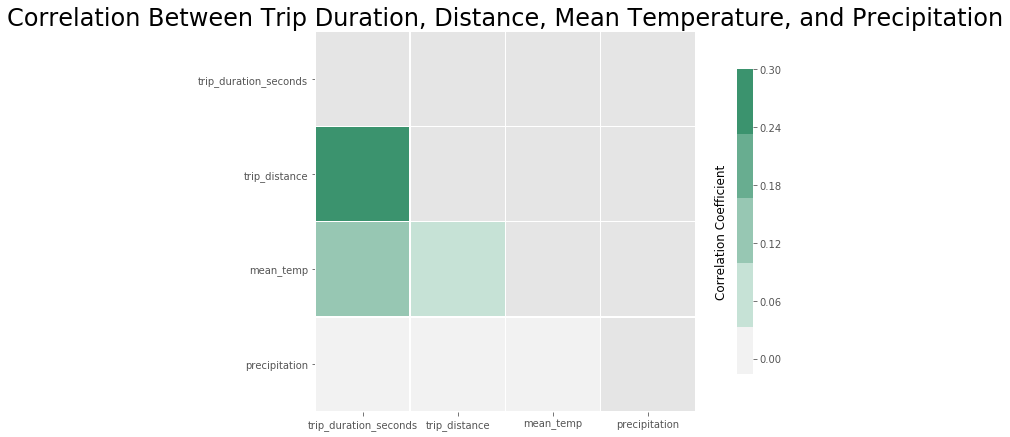

In [52]:
# The idea and adapted code for this visualization was taken from
# this very cool article on EDA, written by Yassien Shaalan: 
# https://blog.growingdata.com.au/a-guided-introduction-to-exploratory-data-analysis-eda-using-python/

# Restrict dataframe to the columns of interest
sub = df[['trip_duration_seconds', 'trip_distance',
          'mean_temp', 'precipitation']]

corr =  sub.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots()
# Generate a custom diverging colormap
cmap = sns.diverging_palette(275, 150, s=80, l=55, n=9)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})


ax.text(4.2, 1.5, "Correlation Coefficient", fontsize=12, rotation=90)
plt.title("Correlation Between Trip Duration, Distance, Mean Temperature, and Precipitation",
          fontsize=24)
plt.yticks(rotation=0)
plt.show()

We can indeed see that there isn't much going on between our measurements of trip length and weather statistics. Mean temperature has a very weak positive correlation with trip duration and trip distance, while precipitation produces values very close to zero. This means that the tendencies we saw stem from how the number of trips distribute under mean temperature and precipitation, but these weather statistics have very little to no effect on our two definitions of trip length.

As a by-product of this visualization we can also see what we discussed in part 1. of this analysis - there is a positive association between trip duration and trip distance, but this value is also fairly low due to the great variance in the data.

# Conclusion

In this report, we defined trip length in two ways: by its duration in seconds, and by the straight line distance between its start and stop stations.

The raw data came with many flaws, and it is possible that there are many more that were left unnoticed. We removed trips with absurd durations and average speeds, and also trips for which station name inconsistencies made it impossible to compute trip distance. In total, we reduced the dataset by around 40%, down to 1.2 million observations.

We noticed a positive association between our two definitions of trip length. Very roughly it seemed like the relationship is exponential, but the data has a huge amount of variance.

When looking at how Toronto Bike Share members compare to casual users using a temporary pass, it appeared as if casual users like to 'get their money's worth' by embarking on trips that had substantially longer durations. The same could not be said about trip distance, however: there did not appear to be any noticeable difference there. We also noticed that, to some extent, casual users frequently took more time to cover the same amount of distance as members, reinforcing the idea of casual users making sure to fully use what they paid for. The large majority of trips were completed by members.

There were nearly 5 times more trips completed during summer and autumn months compared to winter and spring. However, when looking at the distributions of our two definitions of trip length relative to the seasons, we did not notice too many differences. Still, one could notice how trips during summer both took more time and were longer in distance compared to winter, but these differences could be insignificant.

We scraped data from Canada's historical climate database for each day in the scope of this report: July 1st 2016 - December 31st 2017. We joined this data to our trip dataset, showing the mean temperature for the day each trip was started on, and the total precipitation on that day. Looking at how the mean temperature statistic distributed, we saw that there were two modes where trips were more frequent. When we looked at how temperature related to trip length and distance, we saw the similar bimodal phenomenon for both definitions, but as later analysis showed, this phenomenon was very likely caused by how the number of trips distributes relative to mean temperature, rather than mean temperature directly affecting trip length. Still, we saw that there was a very small, but still existent correlation between mean temperature and trip length. Similarly, for precipitation one could notice how trips became shorter in both duration and distance as precipitation increased, but there was no correlation between precipitation and our two definitions of trip length.

# Limitations

Several compormises and generalizations had to be made during this report. We reduced the original Bike Share dataset by about 40%, the majority of which was caused by inconsistencies in bike station names. If we were to fix these issues, we could be more confident in our analysis as we would be using the entire data. As we saw, depending on which categories we looked at, we had sometimes disproportionately taken more data away from certain subgroups, which could have skewed our analysis.

We defined trip distance as the distance between the trip's start and end stations 'as the crow flies', which is a very simplified definition. We unfortunately don't have precise bike tracking data, and finding the actual shortest path between two stations is an incredibly complex task. Unless the stations happened to be on the same straight street, the distance we calculated would not represent the actual distance the cyclist covered. If we had the opportunity for a better measurement of distance, our analysis could be a lot more significant.

We noticed an interesting cluster of trips when visualizing the relationship between trip distance and trip duration and suggested that this is caused by a popular route between two stations. However, in the general and large region of the cluster's distance-duration range, the trips between these two stations accounted for around 10% of all trips in that region. Thus, it is possible that there are other reasons behind the cluster's existence, too.

There are many limitations to our meteorological data. Toronto is a very big city, and the weather in one part of the city is not always the same as in another. With weather data tied to specific parts of the city we could possibly achieve a lot more insight into our ridership data. Similarly, we could improve the precision on our temperature and precipitation statistics. They are an average and a total of the day, respectively - in other words, they are generalizations, summaries. Presumably, most trips happen during the daytime. If there happened to be a very cold or rainy night, but the following day is perfectly pleasant, it might not affect ridership numbers, but this would be interpreted differently in our analysis.

Throughout this report we mainly relied on visualizations and summary statistics to analyze the data, which on many occasions meant that we couldn't conclude if things were one way or the other. Many of these questions could be better answered by analysing them using a more complex methodology, suggestions for some of which are provided in the following extensions section.

# Extensions

This section summarises some of the questions that were left open throughout the report, and tries to suggest potential ways of answering them.

Were we given tremendous amounts of computing power, one could come up with a solution to compute the shortest realistic path a cyclist could have taken to go from the start station to the end. This way we could compute an expected travel time, and compare it to the actual duration, which could provide many interesting insights. This could be achieved by using various Geographic Information Systems techniques.

We noticed an interesting cluster of trips when visualizing the relationship between trip distance and trip duration. These trips appeared to have a noticeably faster average speed than other trips, and we discovered that this is largely caused by a popular route between two stations: 161 Bleecker St. and York St. / Queens Quay W. We could not answer, due to insufficient data, why Bike Share users were able to cover this distance so much quicker. This could be caused by there being substantially better infrastructure or less traffic between those two stations, or perhaps it is a popular commute route, so people don't have the time to wait around when biking from home to work or the other way around. Both of these proposals could be researched, or maybe there is something completely different going on. If we had a way to find out reasonable realistic paths between stations, and combined that with infrastructure, traffic, and commute data, we could possibly be able to come up with an explanation.

We saw how trip frequency distributed bimodally when looking at the mean temperature on the day of each trip. It could be very interesting to look into why this is - is this just a product of how the climate and people's trip frequency fall together, or do people actually have two ranges of temperatures during which they prefer to get on a bike. Should one research this, the first question to figure out would be whether this observation is possible because there are certain times in the year when ridership reaches its peak, and that's when the corresponding temperatures happen to occur. If that is not the case, this could be a very interesting discovery to further look into.

***